In [1]:
import pandas as pd
import numpy as np

# plots
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
%matplotlib inline

### LightGBM

In [2]:
df_train = pd.read_csv('../data/train_con_features_encoded.csv', index_col='Unnamed: 0')
df_test = pd.read_csv('../data/test_con_features_encoded.csv', index_col='Unnamed: 0')
display(df_train.head())

,id,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,idzona,lat,lng,...,cantidad_palabras_descripcion,relacion_palabras_descripcion,es_avenida,es_ciudad_capital,ciudad_turistica_top15,anio,mes,tipodepropiedad_count,ciudad_count,provincia_count
0,254099,8.116114,2.0,1.0,2.0,80.0,80.0,23533.0,NaN,NaN,...,0,0.000000,1,0,0,2015,8,57341,11014,58790
1,53461,10.000000,3.0,2.0,2.0,268.0,180.0,24514.0,19.310205,-99.227655,...,1,0.007968,1,0,0,2013,6,19297,1905,58790
2,247984,5.000000,3.0,2.0,2.0,144.0,166.0,48551.0,NaN,NaN,...,10,0.046957,0,0,0,2015,10,141717,793,21238
3,209067,1.000000,2.0,1.0,1.0,63.0,67.0,53666.0,19.301890,-99.688015,...,0,0.000000,0,0,0,2012,3,141717,154,41607
4,185997,10.000000,2.0,1.0,1.0,95.0,95.0,47835.0,NaN,NaN,...,1,0.074108,0,0,0,2016,6,57341,10360,21238


In [3]:
#Guardo y remuevo la columna id de los datos
id_col = df_test['id']
df_train = df_train.drop(['id'], axis=1)
df_test = df_test.drop(['id'], axis=1)

#Separo features de entrenamiento del precio
feature_cols = df_train.columns.tolist()
feature_cols.remove('precio')


X = df_train[feature_cols]
y = df_train['precio']

feature_cols

['antiguedad',
 'habitaciones',
 'garages',
 'banos',
 'metroscubiertos',
 'metrostotales',
 'idzona',
 'lat',
 'lng',
 'gimnasio',
 'usosmultiples',
 'piscina',
 'escuelascercanas',
 'centroscomercialescercanos',
 'cantidad_amenities',
 'cantidad_servicios',
 'relacion_metros',
 'metros_por_habitacion',
 'metros_por_bano',
 'metros_por_amenities',
 'bano_por_habitacion',
 'garages_por_habitacion',
 'precio_prom_ciudad',
 'precio_prom_propiedad',
 'provincia_top5',
 'seguridad_descripcion',
 'moderno_descripcion',
 'hermoso_descripcion',
 'estado_descripcion',
 'seguridad_titulo',
 'moderno_titulo',
 'hermoso_titulo',
 'estado_titulo',
 'cantidad_palabras_descripcion',
 'relacion_palabras_descripcion',
 'es_avenida',
 'es_ciudad_capital',
 'ciudad_turistica_top15',
 'anio',
 'mes',
 'tipodepropiedad_count',
 'ciudad_count',
 'provincia_count']

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(180000, 43) (180000,)
(60000, 43) (60000,)


In [5]:
import lightgbm as lgb
from sklearn import metrics

'''clf = lgb.LGBMRegressor()

#ajustar
gridParams = {
    'learning_rate': [0.05],
    'num_leaves': [90,200],
    'boosting_type' : ['gbdt'],
    'objective' : ['regression'],
    'max_depth' : [5,6,7,8],
    'random_state' : [501], 
    'colsample_bytree' : [0.5,0.7],
    'subsample' : [0.5,0.7],
    'min_split_gain' : [0.01],
    'min_data_in_leaf':[10],
    'metric':['mae']
    }

grid = RandomizedSearchCV(clf,gridParams,verbose=1,cv=10,n_jobs = -1,n_iter=10)
grid.fit(X_train,y_train)

grid.best_params_'''

"clf = lgb.LGBMRegressor()\n\n#ajustar\ngridParams = {\n    'learning_rate': [0.05],\n    'num_leaves': [90,200],\n    'boosting_type' : ['gbdt'],\n    'objective' : ['regression'],\n    'max_depth' : [5,6,7,8],\n    'random_state' : [501], \n    'colsample_bytree' : [0.5,0.7],\n    'subsample' : [0.5,0.7],\n    'min_split_gain' : [0.01],\n    'min_data_in_leaf':[10],\n    'metric':['mae']\n    }\n\ngrid = RandomizedSearchCV(clf,gridParams,verbose=1,cv=10,n_jobs = -1,n_iter=10)\ngrid.fit(X_train,y_train)\n\ngrid.best_params_"

In [69]:
best_params = {
    'learning_rate': 0.04,      #best=0.04   MAE=520061  COUNT ENCODED ---> k=50
    'num_leaves': 512,          #best=512
    'objective' : 'regression', 
    'max_depth' : 12,           #best=12
    'random_state' : 501,       #best=501
    'colsample_bytree' : 0.9,   #best=0.7
    'subsample' : 0.9,          #best=0.7
    'min_data_in_leaf':10,      #best=10
    'metric':['mae']
    }

In [70]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

LightGBM = lgb.train(best_params, lgb_train, num_boost_round=1500, valid_sets=lgb_eval, early_stopping_rounds=10)

[1]	valid_0's l1: 1.57214e+06
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 1.5249e+06
[3]	valid_0's l1: 1.47972e+06
[4]	valid_0's l1: 1.43644e+06
[5]	valid_0's l1: 1.39566e+06
[6]	valid_0's l1: 1.35672e+06
[7]	valid_0's l1: 1.31931e+06
[8]	valid_0's l1: 1.28401e+06
[9]	valid_0's l1: 1.24981e+06
[10]	valid_0's l1: 1.21764e+06
[11]	valid_0's l1: 1.18727e+06
[12]	valid_0's l1: 1.15793e+06
[13]	valid_0's l1: 1.13005e+06
[14]	valid_0's l1: 1.10331e+06
[15]	valid_0's l1: 1.07827e+06
[16]	valid_0's l1: 1.05456e+06
[17]	valid_0's l1: 1.03198e+06
[18]	valid_0's l1: 1.01006e+06
[19]	valid_0's l1: 989579
[20]	valid_0's l1: 970047
[21]	valid_0's l1: 951564
[22]	valid_0's l1: 933878
[23]	valid_0's l1: 916945
[24]	valid_0's l1: 900692
[25]	valid_0's l1: 885462
[26]	valid_0's l1: 871080
[27]	valid_0's l1: 857438
[28]	valid_0's l1: 844318
[29]	valid_0's l1: 831949
[30]	valid_0's l1: 820033
[31]	valid_0's l1: 808756
[32]	valid_0's l1: 798037
[33]	valid_0's l1: 787940
[

[306]	valid_0's l1: 543210
[307]	valid_0's l1: 543135
[308]	valid_0's l1: 543039
[309]	valid_0's l1: 542907
[310]	valid_0's l1: 542877
[311]	valid_0's l1: 542841
[312]	valid_0's l1: 542771
[313]	valid_0's l1: 542696
[314]	valid_0's l1: 542617
[315]	valid_0's l1: 542511
[316]	valid_0's l1: 542425
[317]	valid_0's l1: 542339
[318]	valid_0's l1: 542292
[319]	valid_0's l1: 542224
[320]	valid_0's l1: 542147
[321]	valid_0's l1: 542086
[322]	valid_0's l1: 541992
[323]	valid_0's l1: 541937
[324]	valid_0's l1: 541952
[325]	valid_0's l1: 541922
[326]	valid_0's l1: 541875
[327]	valid_0's l1: 541740
[328]	valid_0's l1: 541642
[329]	valid_0's l1: 541564
[330]	valid_0's l1: 541509
[331]	valid_0's l1: 541418
[332]	valid_0's l1: 541356
[333]	valid_0's l1: 541290
[334]	valid_0's l1: 541232
[335]	valid_0's l1: 541163
[336]	valid_0's l1: 541102
[337]	valid_0's l1: 541039
[338]	valid_0's l1: 540986
[339]	valid_0's l1: 540866
[340]	valid_0's l1: 540840
[341]	valid_0's l1: 540765
[342]	valid_0's l1: 540684
[

[611]	valid_0's l1: 532224
[612]	valid_0's l1: 532206
[613]	valid_0's l1: 532178
[614]	valid_0's l1: 532140
[615]	valid_0's l1: 532129
[616]	valid_0's l1: 532112
[617]	valid_0's l1: 532104
[618]	valid_0's l1: 532108
[619]	valid_0's l1: 532082
[620]	valid_0's l1: 532059
[621]	valid_0's l1: 532032
[622]	valid_0's l1: 532005
[623]	valid_0's l1: 531974
[624]	valid_0's l1: 531977
[625]	valid_0's l1: 531943
[626]	valid_0's l1: 531924
[627]	valid_0's l1: 531883
[628]	valid_0's l1: 531876
[629]	valid_0's l1: 531841
[630]	valid_0's l1: 531836
[631]	valid_0's l1: 531786
[632]	valid_0's l1: 531765
[633]	valid_0's l1: 531753
[634]	valid_0's l1: 531731
[635]	valid_0's l1: 531726
[636]	valid_0's l1: 531680
[637]	valid_0's l1: 531658
[638]	valid_0's l1: 531626
[639]	valid_0's l1: 531595
[640]	valid_0's l1: 531582
[641]	valid_0's l1: 531583
[642]	valid_0's l1: 531566
[643]	valid_0's l1: 531551
[644]	valid_0's l1: 531556
[645]	valid_0's l1: 531520
[646]	valid_0's l1: 531511
[647]	valid_0's l1: 531486
[

[917]	valid_0's l1: 527722
[918]	valid_0's l1: 527713
[919]	valid_0's l1: 527684
[920]	valid_0's l1: 527682
[921]	valid_0's l1: 527659
[922]	valid_0's l1: 527659
[923]	valid_0's l1: 527647
[924]	valid_0's l1: 527651
[925]	valid_0's l1: 527617
[926]	valid_0's l1: 527607
[927]	valid_0's l1: 527584
[928]	valid_0's l1: 527566
[929]	valid_0's l1: 527549
[930]	valid_0's l1: 527511
[931]	valid_0's l1: 527504
[932]	valid_0's l1: 527511
[933]	valid_0's l1: 527506
[934]	valid_0's l1: 527464
[935]	valid_0's l1: 527458
[936]	valid_0's l1: 527452
[937]	valid_0's l1: 527444
[938]	valid_0's l1: 527450
[939]	valid_0's l1: 527438
[940]	valid_0's l1: 527419
[941]	valid_0's l1: 527416
[942]	valid_0's l1: 527424
[943]	valid_0's l1: 527414
[944]	valid_0's l1: 527410
[945]	valid_0's l1: 527398
[946]	valid_0's l1: 527383
[947]	valid_0's l1: 527373
[948]	valid_0's l1: 527378
[949]	valid_0's l1: 527386
[950]	valid_0's l1: 527377
[951]	valid_0's l1: 527377
[952]	valid_0's l1: 527375
[953]	valid_0's l1: 527376
[

KeyboardInterrupt: 

In [50]:
LightGBM_pred = LightGBM.predict(X_test, num_iteration=LightGBM.best_iteration)

In [21]:
from sklearn.metrics import mean_absolute_error

LightGBM_mae = mean_absolute_error(y_test, LightGBM_pred)
LightGBM_mae_train = mean_absolute_error(y_train, LightGBM.predict(X_train, num_iteration=LightGBM.best_iteration))
print(f"LightGBM (train): {LightGBM_mae_train:.5f}")
print(f"LightGBM: {LightGBM_mae:.5f}")
print("------------------------------")

LightGBM (train): 336847.81594
LightGBM: 527242.14611
------------------------------


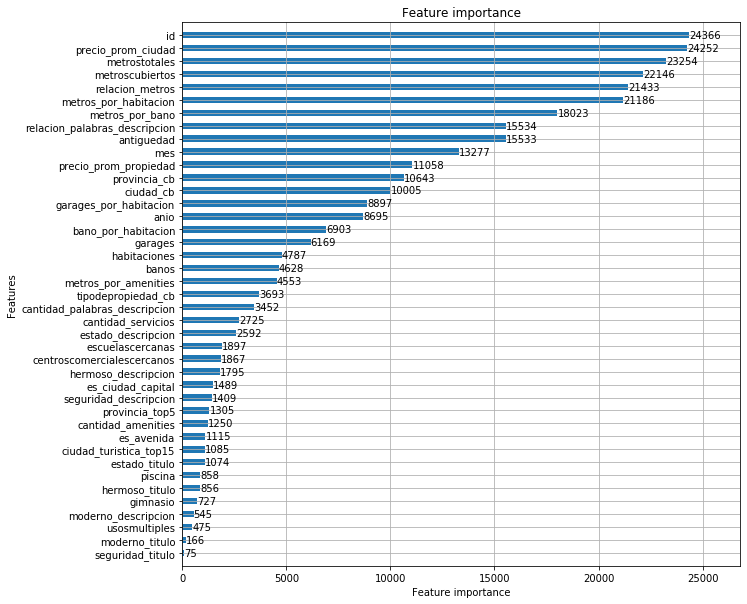

In [36]:
ax = lgb.plot_importance(LightGBM, height=0.5)
fig = ax.figure
fig.set_size_inches(10, 10)

In [37]:
LightGBM_pred_submit = LightGBM.predict(df_test, num_iteration=LightGBM.best_iteration)

In [38]:
resultado_submit = pd.DataFrame(index=df_test.index)
resultado_submit['id'] = df_test['id']
resultado_submit['target'] = LightGBM_pred_submit
display(resultado_submit.head())
resultado_submit.to_csv('../data/submitLightGBM.csv',index=False)

,id,target
0,4941,7.062873e+06
1,51775,1.036621e+06
2,115253,2.242938e+06
3,299321,1.286775e+06
4,173570,5.866771e+05


#### Score en Kaggle (features => score):
 **1.** ***Usando CatBoost encoded*** y ['id',
 'antiguedad',
 'habitaciones',
 'garages',
 'banos',
 'metroscubiertos',
 'metrostotales',
 'gimnasio',
 'usosmultiples',
 'piscina',
 'escuelascercanas',
 'centroscomercialescercanos',
 'cantidad_amenities',
 'cantidad_servicios',
 'relacion_metros',
 'metros_por_habitacion',
 'metros_por_bano',
 'metros_por_amenities',
 'bano_por_habitacion',
 'garages_por_habitacion',
 'precio_prom_ciudad',
 'precio_prom_propiedad',
 'provincia_top5',
 'seguridad_descripcion',
 'moderno_descripcion',
 'hermoso_descripcion',
 'estado_descripcion',
 'seguridad_titulo',
 'moderno_titulo',
 'hermoso_titulo',
 'estado_titulo',
 'cantidad_palabras_descripcion',
 'relacion_palabras_descripcion',
 'es_avenida',
 'es_ciudad_capital',
 'ciudad_turistica_top15',
 'anio',
 'mes',
 'tipodepropiedad_cb',
 'ciudad_cb',
 'provincia_cb']=> ***573846.94092*** con 'learning_rate': 0.03,
    'num_leaves': 256,
    'objective' : 'regression',
    'max_depth' : 12,
    'random_state' : 501, 
    'colsample_bytree' : 0.7,
    'subsample' : 0.7,
    'min_split_gain' : 0.01,
    'min_data_in_leaf':10,
***LOCAL MAE: 568518.75474***